## DoubleDQN with Prioritized Replay (PER) and Dueling Network Architecture - Watch Trained Models

In [1]:
import math, random, time

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### Required Functions and Model Class for Saved Models

In [5]:
 def eval_plot(rewards):
    clear_output(True)
    plt.figure(figsize=(10,5))
    #plt.ylim((0, 100))
    for agent_reward in rewards:
        plt.title('Track Agents Evaluation Progress')
        plt.plot(agent_reward)

    plt.show()
    
class DuelingDQN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DuelingDQN, self).__init__()
        
        
        self.feature = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs)
        )
        
        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

### Watch the Trained Agent Play - beginner, intermediate, professional

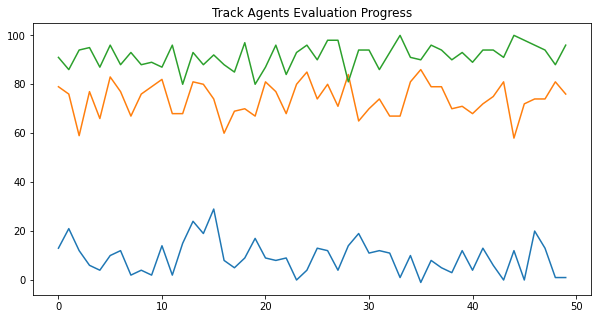

In [8]:
env_id = "Boxing-ram-v0"
env = gym.make(env_id)
env1 = gym.make(env_id)
env2 = gym.make(env_id)
env3 = gym.make(env_id)

beginner = torch.load( "./models/test_%s_250000.model" % env_id)
intermediate = torch.load( "./models/test_%s_500000.model" % env_id)
professional = torch.load( "./models/test_%s_5000000.model" % env_id)

beginner.eval()
intermediate.eval()
professional.eval()

num_episodes = 50

render = True

all_rewards1 = []
episode_reward1 = 0
games_played1 = 0

all_rewards2 = []
episode_reward2 = 0
games_played2 = 0

all_rewards3 = []
episode_reward3 = 0
games_played3 = 0

frame_idx = 0

state1 = env1.reset()
state2 = env2.reset()
state3 = env3.reset()
gaming = True

while gaming:
    env1.render()
    env2.render()
    env3.render()
    time.sleep(0.001)
        
    if games_played1 < num_episodes:
        action1 = beginner.act(state1, 0.01)
        next_state1, reward1, done1, _ = env1.step(action1) 
        state1 = next_state1
        episode_reward1 += reward1
    
    if done1 and games_played1 < num_episodes:
        state1 = env1.reset()
        all_rewards1.append(episode_reward1)
        episode_reward1 = 0
        games_played1 += 1

    if games_played2 < num_episodes:
        action2 = intermediate.act(state2, 0.01)
        next_state2, reward2, done2, _ = env2.step(action2)
        state2 = next_state2
        episode_reward2 += reward2
        
    if done2 and games_played2 < num_episodes:
        state2 = env2.reset()
        all_rewards2.append(episode_reward2)
        episode_reward2 = 0
        games_played2 += 1

    if games_played3 < num_episodes:
        action3 = professional.act(state3, 0.01)
        next_state3, reward3, done3, _ = env3.step(action3)
        state3 = next_state3
        episode_reward3 += reward3
        
    if done3 and games_played3 < num_episodes:
        state3 = env3.reset()
        all_rewards3.append(episode_reward3)
        episode_reward3 = 0
        games_played3 += 1

    if frame_idx % 200 == 0:
        eval_plot([all_rewards1, all_rewards2, all_rewards3])
    
    if games_played1 == num_episodes and games_played2 == num_episodes and games_played3 == num_episodes:
        gaming = False
    
    frame_idx +=1

# Final Plot
eval_plot([all_rewards1, all_rewards2, all_rewards3])
            